<a href="https://colab.research.google.com/github/CecinestpasJonatan/MachineaLearningIntroNotebook/blob/main/MachineLearningIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is machine learning? What is AI? These are question which are commonly discussed amongst academics and will be outside of the scope of this notebook. For practical purposes, machine learning will here be defined as the inferring models from data using numerical methods for the purpose of predicting the behaviour of data not present in the dataset which the model was trained on. AI will be defined as the ability of a system to behave in an intelligent manner.

Practical tips: Each code block can be run by clicking on the play button to the left of each block. All blocks can be run in sequence by clicking CTRL+F9, and as some blocks depends on definitions in the previous blocks this should always be done before rerunnig each block when doing experiments. The language that will be used is Python, the module NumPy will be used for mathematical operations, Matplotlib will be used for plotting, Sklearn and PyTorch will be used for the actual machine learning.

Lets start with an example. Lets say we have aquired measurement data and we want to use this data to generate a model which can predict how the output will change depending on the input data.

Text(0, 0.5, 'Output data')

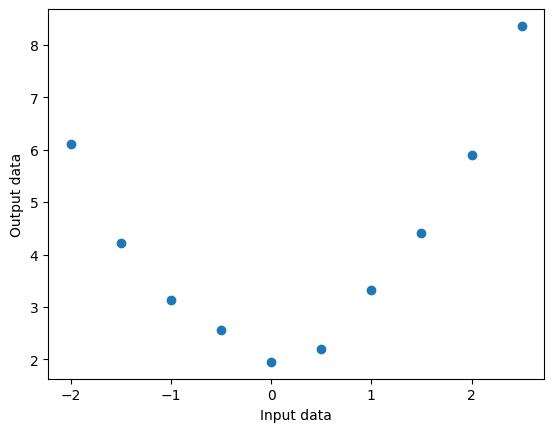

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

#Input data
x = np.linspace(-2, 2.5, 10)
#Output data (DON'T LOOK)
y = x**2 + np.random.randn(10)/5 + 2

plt.scatter(x, y)
plt.xlabel("Input data")
plt.ylabel("Output data")

Even if we don't look at the output function, our intuiton tells us that this data should be generated from some type of quadratic equation, probably with noise interferring with the measurement. Using this knowledge we go back to our first course in linear algebra and apply the least-squared method to fit a curve to our data.

Note: "@" means matrix multiplication, "a**b" means to take a to the power of b.


Text(0, 0.5, 'Output data')

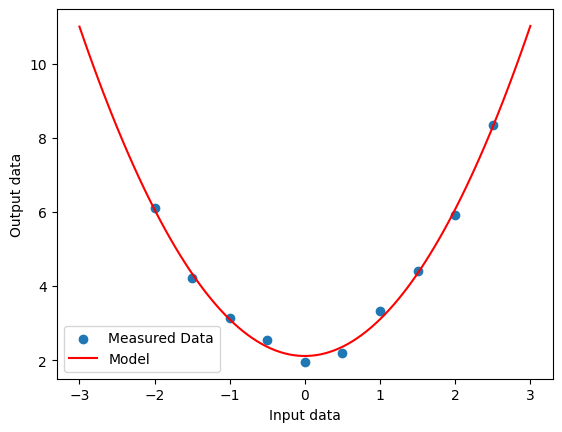

In [2]:
#Ordinary Linear Least squares curve fitting
y_matrix = np.expand_dims(y, axis=-1)
x_matrix = np.repeat(np.expand_dims(x, axis=-1), 3, axis=-1)
x_matrix[:, 0] = 1
x_matrix[:, 2] = x_matrix[:, 2]**2
normal_matrix = x_matrix @ x_matrix.T
normal_matrix_inv = np.linalg.inv(normal_matrix)
b = np.linalg.inv(x_matrix.T@x_matrix)@x_matrix.T@y

x_model = np.linspace(-3, 3, 100)
x_model_matrix = np.repeat(np.expand_dims(x_model, axis=-1), 3, axis=-1)
x_model_matrix[:, 0] = 1
x_model_matrix[:, 2] = x_model_matrix[:, 2]**2
y_model = x_model_matrix @ b

plt.scatter(x, y, label="Measured Data")
plt.plot(x_model, y_model, label="Model", c='r')
plt.legend()

plt.xlabel("Input data")
plt.ylabel("Output data")

There we go! We have generated a model from measurement data using linear curve fitting. Now, all the matrix operations can be simplified using the NumPy library, reducing the code significantly. This method will be used in the next example.

Lets say we are unsure about the order of the polynomlial which shoud be used to fit the data. We can investigate this by testing different orders of the polynomial to see which fits the data the best.

Note: np.poly1d and np.polyfit is used to perform the steps which are done explicitly in the previous example.

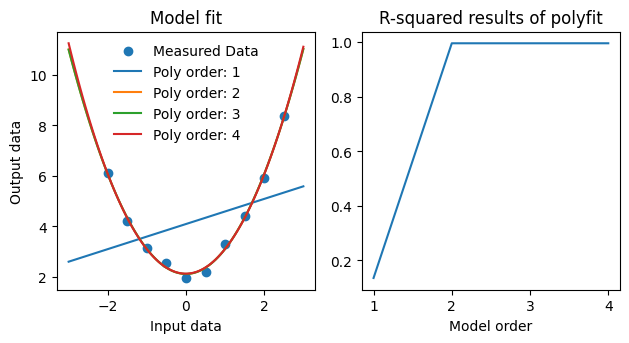

In [3]:
#@title Code
from sklearn.metrics import r2_score

test_order= [1, 2, 3, 4]
x_model = np.linspace(-3, 3, 100)
residuals = []

fig, ax = plt.subplots(ncols=2)

ax[0].scatter(x, y, label="Measured Data")

for p_order in test_order:
  test_model = np.poly1d(np.polyfit(x, y, p_order))
  y_model = test_model(x_model)
  ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
  residuals.append(r2_score(y, test_model(x)))

ax[0].legend(frameon=False)
ax[0].set_xlabel("Input data")
ax[0].set_ylabel("Output data")
ax[0].title.set_text('Model fit')

ax[1].plot(test_order, residuals)
ax[1].title.set_text("R-squared results of polyfit")
ax[1].set_xlabel("Model order")

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

plt.tight_layout()

We see that polynomials of order > 1 all estimate the data pretty well, with R-squared values close to 1. However, given the nature of the data, it seems that using qubic or higher order of 2 seems like a waste. Is there a way to select models which fit the data well but is not too complicated?

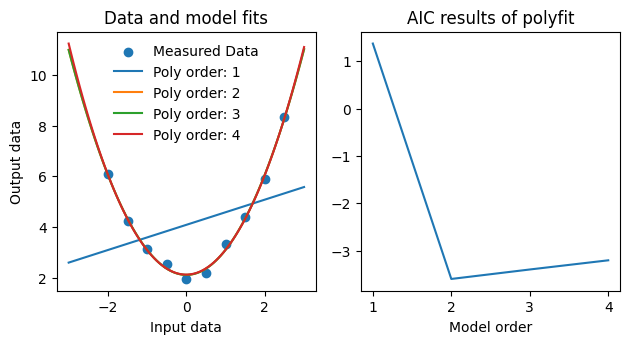

In [4]:
#@title Code
from sklearn.metrics import r2_score

test_order= [1, 2, 3, 4]
x_model = np.linspace(-3, 3, 100)
residuals = []

fig, ax = plt.subplots(ncols=2)
ax[0].scatter(x, y, label="Measured Data")

for p_order in test_order:
  test_model = np.poly1d(np.polyfit(x, y, p_order))
  y_model = test_model(x_model)
  ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
  res = np.sum((y - test_model(x))**2)
  aic = np.log(res/len(x)) + 2*p_order/len(x)
  residuals.append(aic)

ax[0].legend(frameon=False)
ax[0].set_xlabel("Input data")
ax[0].set_ylabel("Output data")
ax[0].title.set_text('Data and model fits')

ax[1].plot(test_order, residuals)
ax[1].title.set_text("AIC results of polyfit")
ax[1].set_xlabel("Model order")

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
plt.tight_layout()
plt.show()


In this result we see that something called AIC (Akaike Information Criterion). This is a value which measures how well a model fits the data, but which penalizes too complex models. The derivation is based in information theory and the details is not important for this example. The formula for this quantity is:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/fe67d436d9064a370cbe800b24b05ee8a68d491b)

Where k is the order of the model and L_hat is the maximum liklihood estiamtion of the data.

However, we see that this value correctly predicts that using a polynomial of order 2 is the best fit for this model.

Lets try what happens if we change the parameters of the data:

In [5]:
#@title Code
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from sklearn.metrics import r2_score

def regression_example(p1=0, p2=1, p3=0, p4=0, noise=0.2, x_min=-2, x_max=2, n_points=10, new_points=False):
  x = np.linspace(x_min, x_max, n_points)
  y = p1*x + p2*x**2 + p3*x**3 + p4*x**4 + np.random.randn(n_points)*noise
  test_order= [1, 2, 3, 4]
  x_model = np.linspace(x_min*1.2, x_max*1.2, n_points*5)
  residuals = []
  models = []

  fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
  ax[0].scatter(x, y, label="Measured Data")

  for p_order in test_order:
    test_model = np.poly1d(np.polyfit(x, y, p_order))
    y_model = test_model(x_model)
    ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
    res = np.sum((y - test_model(x))**2)
    aic = np.log(res/len(x)) + 2*p_order
    residuals.append(aic)
    models.append(test_model)

  if new_points:
    new_data_points = x = np.linspace(x_min*1.2, x_max*1.2, int(n_points/2))
    min_aic = min(residuals)
    ind_model = residuals.index(min_aic)
    best_model = models[ind_model]

    new_y = best_model(new_data_points)
    ax[0].scatter(new_data_points, new_y, label="New data for best model", marker='x')


  ax[0].legend(frameon=False,)
  ax[0].set_xlabel("Input data")
  ax[0].set_ylabel("Output data")
  ax[0].title.set_text('Data and model fits')

  ax[1].plot(test_order, residuals)
  ax[1].title.set_text("AIC results of polyfit")
  ax[1].set_xlabel("Model order")
  ax[1].set_xticks([1,2,3,4])

  ax[0].set_box_aspect(1)
  ax[1].set_box_aspect(1)
  plt.tight_layout()
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(regression_example, p1=widgets.FloatSlider(value=1, min=-10, max=10),
                 p2=widgets.FloatSlider(value=1, min=-10, max=10),
                 p3=widgets.FloatSlider(value=0, min=-10, max=10),
                 p4=widgets.FloatSlider(value=0, min=-10, max=10),
                 noise=widgets.FloatSlider(value=0.2, min=0, max=10),
                 x_min=widgets.FloatSlider(value=-2, min=-10, max=-0.1),
                 x_max=widgets.FloatSlider(value=2, min=0.1, max=10),
                 n_points=widgets.IntSlider(value=10, min=3, max=100),
                 new_points=widgets.Checkbox(
                 value=False,
                 description='Generate new data',
                 disabled=False))

display(output)



interactive(children=(FloatSlider(value=1.0, description='p1', max=10.0, min=-10.0), FloatSlider(value=1.0, de…

Output()

One observation here is that the best AIC scoring order of the model and the order of the process which generated to the data is not always the same. This is reflected by the fact that less complex models are scored higher when there is high uncertainty in which model performs the best.

Well done! You have now done your first machine learning task. While simple, this is essentially what machine learning entails: acquring data, using the data to train a model, evaluate the model on the avaiable data and select the most appropriate model according to performance and complexity. When we have this model, that is, an estimate of the polynomial that generates the data, we can use it to generate new datapoints. This is essentially what generative AI is behind the curtain. But how do you generate an image from text? What is the model that is being fitted there? We're getting ahead of ourselves, but this is something worth considering.

There are some observations regarding the methodology shown in this example. Here, we have (correctly) assumed that the noisy data is generated using some type of polynomial function. If we know that the data is the result of a model which can be approximated using a polynomial, or some other analytical model, this approach is often the most robust and fastest way to fit a machine learning model to the data. It is however very uncommon that we are afforded this luxury, usually the relation between the data and the generating model is either completely unknown or only vaguely implied by the measurements. For these reasons a common approach is to not assume any model at all when fitting the data and fit a machine learning model which has no parametric correspondence to the process generating the training data. This is called parameter free machine learning, which provides a powerful methodology for training models on a large variety of data. This will be the approach going forward in this notebook.


Now it's time to jump ahead to more modern methods, and change the task we want to perform from estimating a certain quantity (regression) to separating the data into different groups (classification).

Imaging that we have some 2-dimensional data, which are generated from two different classes:

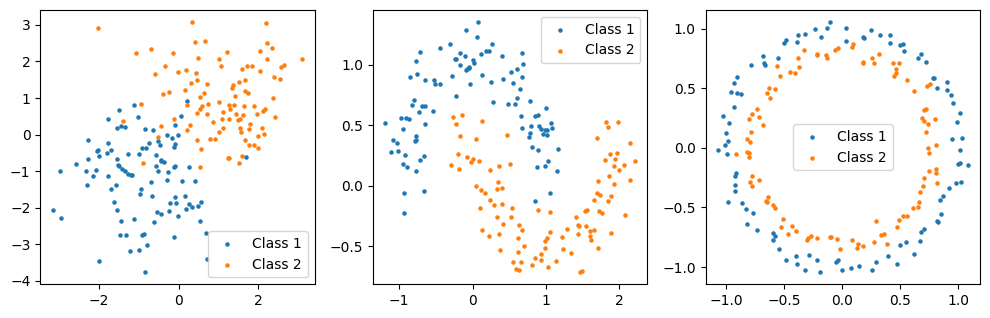

In [6]:
#@title Code
from sklearn.datasets import make_blobs, make_moons, make_circles
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import numpy as np

n_points = 200

X_blob, y_blob = make_blobs(n_samples=n_points, centers=[[-1,-1.],[1,1]], n_features=2, random_state=1337)
X_moon, y_moon = make_moons(n_samples=n_points,  random_state=1337, noise=0.15)
X_circles, y_circles = make_circles(n_samples=n_points, random_state=1337, noise=0.04)

data = [[X_blob, y_blob],[X_moon, y_moon],[X_circles, y_circles]]

fig, axs = plt.subplots(ncols=3, figsize=(10,30))

for data_fig, ax in zip(data, axs):
  X = data_fig[0]
  y = data_fig[1]
  ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
  ax.scatter(X[y==1, 0], X[y==1, 1], s=5)
  ax.legend(["Class 1", "Class 2"])
  #ax.set(aspect='equal')
  ax.set_box_aspect(1)

plt.tight_layout()

Now our task is to classify this data so that they belong to the correct class. That is, our model must be able to classify the maximum number or values as belonging to the correct class while minimizing the amount of data points which are categorized as beloning to the wrong class.

One method would be to compare each sample to a number of the closest samples, and classifying the data as beloning to the class which has the most samples beloning to a certain class in this selection of data. Example as per Wikipedia:

![image.gif](https://upload.wikimedia.org/wikipedia/commons/7/78/KNN_decision_surface_animation.gif)

Try it out in our synthetic data sets to see how the dicision boundary changes with the number of neighbors used for classification.

In [7]:
#@title Code
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

def KNN_clf(neighbors=1):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = KNeighborsClassifier(n_neighbors=neighbors)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(KNN_clf, neighbors=widgets.IntSlider(value=5, min=2, max=15))
display(output)


interactive(children=(IntSlider(value=5, description='neighbors', max=15, min=2), Output()), _dom_classes=('wi…

Output()

This method is called K-nearest neighbors classifier, and requires no explicit training. Instead, classification is done by looking up the datapoints which are the closest the samples to be classified. While often very useful, it requires that all "training" data is stored for classifying new data points, and classifying new data points requires the model to search through all training data to find the closest data points, which can become very slow as the data set grows into the millions.

One potentially more robust method would be to find a line which can be used to divide the dataset into the different classes. However, a lot of datasets would be impossible to divide using a straight line normally, as seen in our previous examples. But here's the trick: It might be able to divide it using a straight line if the data has been transformed using some form of operation. This is commonly used trick, called the 'kernel trick', is used to transform the data, potenitally to higher dimensional representation, where the partition and classification can be performed linearly. After this decision boundary has been found the model is transformed back into the original data space, making this a very powerful method for finding complex partitions of a data set.

In the next example 'linear' means that a dicision boundary is drawn straight through the dataset without any transformation. 'poly' means that the data is transformed using a third degree polynomial, and 'rbf' means that an exponential transform is used.

In [8]:
#@title Code
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

def SVC_clf(kernel='linear', C=1, margin=False):

  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = svm.SVC(kernel=kernel, C=C)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    if margin:
      DecisionBoundaryDisplay.from_estimator(
          **common_params,
          response_method="decision_function",
          plot_method="contour",
          levels=[-1, 0, 1],
          colors=["k", "k", "k"],
          linestyles=["--", "-", "--"],
      )

    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(SVC_clf, kernel=widgets.RadioButtons(options=['linear', 'poly','rbf'], description='Kernel type:'), C=widgets.FloatLogSlider(value=1, base=10, min=-4, max=2, step=0.2),
    margin=widgets.Checkbox(
    value=False,
    description='Show margins',
    disabled=False))

display(output)

interactive(children=(RadioButtons(description='Kernel type:', options=('linear', 'poly', 'rbf'), value='linea…

Output()

This method of machine learning is called Support Vector Machines. This algorithm tries to find a dicision boundary between classes which minimizes the incorrectly classified data, as well as maximizing the distance between the boundary and incorrectly classified samples. These samples that lies on the edge of this margin between partitions are called support vectors. Here we see that it's not possible to find a straight line which partitions the data into two parts without incorrectly classify any data, but using kernel transformations it is possible to partition the data accurately. The most common kernel transformation is called 'rbf', or 'radial basis function', which can be seen as a infinite dimensional polynomial transformation. This function defines the distance between two data points as:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/c16fd6c515412f96a57506103896178d0e8af77d)

The 'C' parameter determines how much the algorithm will 'punish' incorretly labeled data, meaning that a high 'C' value will nudge the algorithm towards finding a more complex decision boundary.

One problem with this algorithm is that it does not scale well with increasing data samples and dimensions, as well as needing to decide what type of kernel to use for data transformations with no flexibility for different parts of the dataset. Evidently, a more expressive method which can approximate functions for different parts of the dataset separably is need.


One method of partitioning the dataset into different parts is to build a decision tree. Using this method the model tries to learn different hierarchies of partitions of the dataset which can be used in the end to classify different data samples. One example per wikipedia in how such a tree can look like:

![titanic.png](https://upload.wikimedia.org/wikipedia/commons/e/eb/Decision_Tree.jpg)

'sibsp' here referes to the number of sibling aboar the Titanic. Here the algorithm has learned that the most important factor in surviving is whether you are male or female. Then, if you are male, the most important factor is your age, and after that the most important factor is the number of siblings aboard. Note that this hierarchy is dependent on the constraints in the depth of the tree, how many datapoints are needed to split a tree, and how many datapoints are needed to become a leaf point.

The decision tree method, as we see, uses a number of parameters to decide how to build the descision tree, where the max_depth parameter decides the maximum level of decision that the tree can consist of, while min_split and min_leaf decides how many data samples are needed for a decision to be made at each node and lead, respectively. Increasing the maximum depth will enable the decision tree to model more complex data, while increasing the min_split and min_leaf values will make the classification "safe", i.e. the algorithm will look at larger clusters of data instead of single data points.

In [9]:
#@title Code
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

def Tree_clf(max_depth=None, min_samples_split=2, min_samples_leaf=1):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(Tree_clf, max_depth=widgets.IntSlider(value=5, min=0, max=50, description='Max_depth'),
                 min_samples_split=widgets.IntSlider(value=2, min=2, max=50, description='Min_split:'),
                 min_samples_leaf=widgets.IntSlider(value=1, min=1, max=50, description='Min_leaf'),)
display(output)


interactive(children=(IntSlider(value=5, description='Max_depth', max=50), IntSlider(value=2, description='Min…

Output()

But what if we want to both partition the dataset into different parts, and still use some form of function to models the individual parts of the dataset?

One way of expressing arbitrary functions is to use mulitple layers of individual estimators, which are combined to produce the final estimation. These estimators are able to partition the dataset into subfields where they contribute to the esimation if active, otherwise they will remain inactive. This allows for non-linear estimation while enabling training gradually by comparing individual or a subset of samples to the correct data:

In [10]:
#@title Code

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

def get_activations(clf, X, y):
  l1 = (clf.coefs_[0].T@X.T).T + clf.intercepts_[0].T
  l1_mask = l1 > 0
  l1_act = l1 * l1_mask

  l2 = (clf.coefs_[1].T@l1_act.T).T + clf.intercepts_[1]
  l2_mask = l2 > 0
  l2_act = l2 * l2_mask

  output = (clf.coefs_[2].T@l2_act.T).T + clf.intercepts_[2]
  return l1_act, l2_act, output

def MLP_clf(layer1=10, layer2=10, learning_rate=0.05, iterations=100):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  clf_base = MLPClassifier(hidden_layer_sizes=(layer1, layer2), learning_rate_init=learning_rate,
                      learning_rate='invscaling', random_state=1337, warm_start=True,
                      activation='relu', max_iter=iterations)
  clf_list = [clone(clf_base), clone(clf_base), clone(clf_base)]
  for data_fig, ax, clf in zip(data, axs, clf_list):
    X = data_fig[0]
    y = data_fig[1]
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="predict",
                plot_method="pcolormesh",
                alpha=0.3,)
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(MLP_clf, layer1=widgets.IntSlider(value=10, min=1, max=50),
                 layer2=widgets.IntSlider(value=10, min=1, max=50),
                 learning_rate=widgets.FloatLogSlider(value=0.05, base=10, min=-3, max=0, step=0.2),
                 iterations=widgets.IntSlider(value=200, min=1, max=500),)
display(output)


interactive(children=(IntSlider(value=10, description='layer1', max=50, min=1), IntSlider(value=10, descriptio…

Output()

This is exactly what neural networks do! The architecture of the network allows for extremely powerful estimations, while being relatively "cheap" to train. The power of neural networks comes from the fact that a neuron can be "on" or "off", that is, each neuron has a non-linear activation function which allows the network to dedicate separate parts of the dataset to separate combinations of neurons. There are many different activation functions, all used for different specific tasks, a selection of these are shown below.

![activation.jpg](https://media.licdn.com/dms/image/v2/C4E12AQFqIFCj71YJPw/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1620764635917?e=2147483647&v=beta&t=BHcXCFwNSDCnYuWH6F1y0xs9DMxv7zClOx6V34fHqKw)

This example uses a intial two layer neural network with 10 neurons each using the Sklearn module, but usually this is done using more specialized libraries which provide huge flexibility in constructing and training neural networks of many layers, called deep learning.

Almost all deep neural networks are trained using a method called Gradient Descent, and adjusting the parameters for each layer is done using a method called back-propagation. Put simply, this method trains the network iteratively by comparing the results as inferred from the model to the actual truth, and slightly adjusting the parameters to predict the correct results for each sample. How much the network corrects its prediction for each sample is called the learning rate, and needs to be chosen carefully to ensure that network doesn't "overcorrect" for each individual sample, but still corrects it enough so that is can learn to predict correcly without excessive number of iterations.

A large amount of modern machine learning models are based in part or fully on neural network architectures. Going forward in this notebook we will focus on how to train these neural networks for different tasks.

Lets try a even more current example:

A common machine learning task is to identify written symbols in order to transcribe images. A common dataset to use to illustrate this is called the MNIST dataset, which consists of 70000 handwritten images of numbers. We will now see if we can use deep learning to identify these handwritten numbers. An example of data points from this dataset i shown below. First download the data by runing the first cell.

In [11]:
#@title Code
!pip install torchview --quiet
!pip install torchviz --quiet
!pip install graphviz --quiet

!pip install umap-learn

import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size_train = 64
batch_size_test = batch_size_train

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                               (0.1307,), (0.3081,))
                               ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                                          transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(
                                          (0.1307,), (0.3081,))
                                          ])),batch_size=batch_size_test, shuffle=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00
Failed to download (trying next):
HTTP Error 

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.8MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.50MB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.07MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



Then plot some examples by running the next cell.

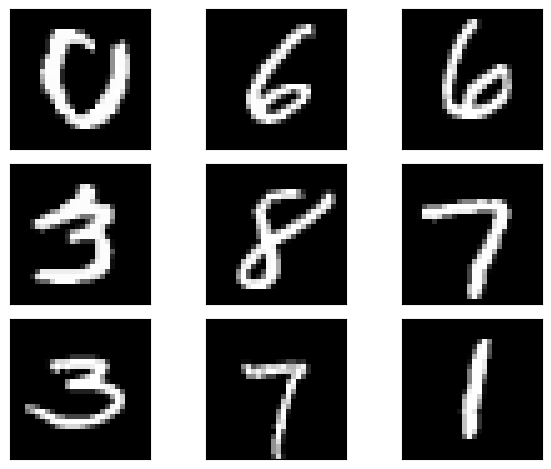

In [12]:
#@title Code
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Now, lets construct a neural network to train how classify these handwritten digits. First we need to construct a network which we want to train. Lets build a network with 2 layers of 64 neurons each. To make our data possible to feed into the network, we need to "flatten" the images into 1D arrays, which can then be used as input for the network. Then, in order to make a prediction, we add an output layer with 10 different neurons, which will represent each of the possible digits. The idea is to make the output neurons represent the likelihood of the input image containing each specific digit.

In [13]:
#@title Code
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return F.log_softmax(x)

learning_rate = 0.01
momentum = 0.5
log_interval = 100
n_epochs = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



Lets visualize the network to make it somewhat more understandable.

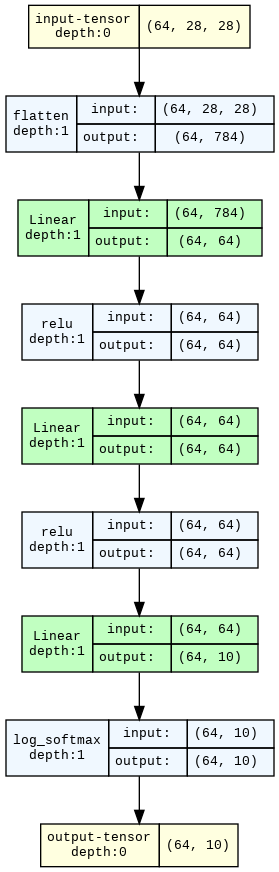

In [14]:
#@title Code
from torchviz import make_dot
import torchvision
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')
model_graph = draw_graph(network, input_size=(64, 28, 28), expand_nested=True)
model_graph.visual_graph



First we have a high level view of the network, shown above. Here we see the input layer, consiting of 64 images being input at once, each image consisting of 28 by 28 pixels. The after the input layer we have the flatten layer, which turns the 2-dimensinal image into a 1-dimensional array. After that we have the first neuron layer, consisting of 64 neurons, each of which are connected to each pixel in the input image. After that there is an activation layer, which sums all inputs to each neuron and calculates what value to pass forward to the next layer. After that there is another layer with 64 neurons, each connected to each neuron in the previous layer, followed by another activation layer.

At the end, we have a layer consisting of 10 neurons. These represent the each digit which we want to predict the input image as belonging to. Each of these neurons takes a weighted sum of the output from the neurons in the previous layer, same as before, but this time the activation function used is called a SoftMax function. This functions normalizes the output of all the neurons in the output layer, generating a probability function. This function is then used to determine which what probability as certain data points belongs to a certain digits class, using a loss function called Categorical Crossentropy.


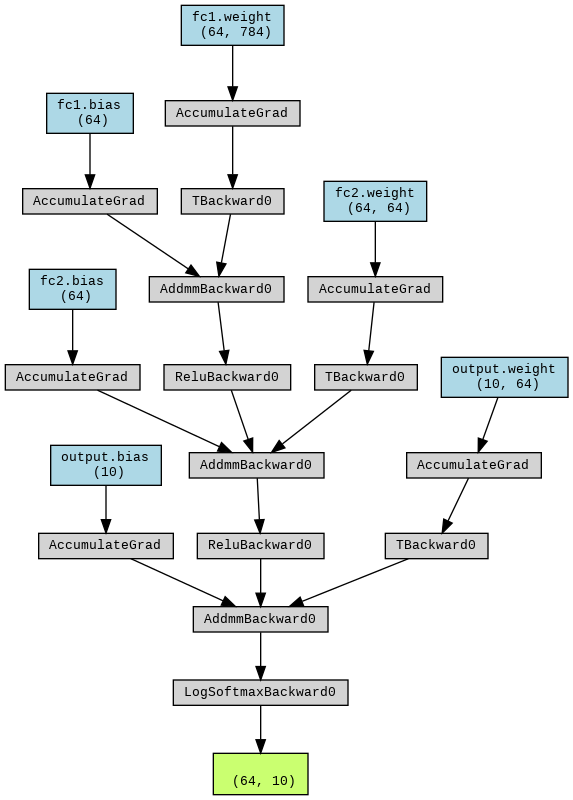

In [15]:
#@title Code
batch = next(iter(train_loader))
yhat = network(batch[0])
make_dot(yhat, params=dict(list(network.named_parameters())))

Here is another view of the network, which is what the computer actually 'sees'. This is the computational graph which is defined in out network architecture above, which includes all computations relating to training and predicting. While not essential to understand for doing some basic training, it is important for debugging some issues which might occury when building a new network.

So, no it's time to actually train our network. The network is trained by predticting the class of each image in the training dataset, 64 at once, and then using the detected error to backpropagate and update the weights of each layer. After each iteration, called an "epoch", the model is tested on a test dataset, which is not used for training. The number of epoch for which the network is trained here are 10 epochs.

In [16]:
#@title Code
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310398
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.207395
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.494945
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.396028
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.342963
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.225908
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.360676
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.224776
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.414245
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.264261

Test set: Avg. loss: 0.2899, Accuracy: 9141/10000 (91.4100%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.126438
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.340502
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.132840
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.454288
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.130875
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.336722
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.262226
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.063442
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.187181

Around 97% accuracy on the test data, that's pretty good! We can have a look at a graph showing the loss as the network is being trained on the data.

Text(0, 0.5, 'negative log likelihood loss')

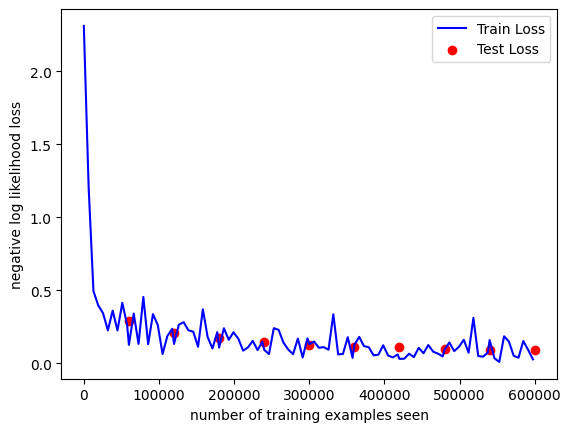

In [17]:
#@title Code
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter[1:], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Now, the question is of course, will the same hold try for other numbers? Lets do a test, by changing the data just a tiny bit, will the accuracy remain?

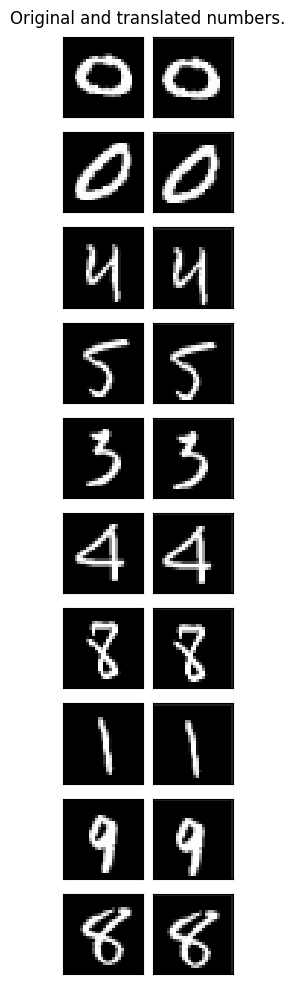

In [18]:
#@title Code
for data, target in test_loader:
  perturbed_numbers = torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data)
  fig = plt.figure(figsize=(2, 10))
  for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(data[i, 0, :, :], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(10, 2, i*2+2)
    plt.imshow(perturbed_numbers[i, 0, :, :], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
  break
plt.suptitle("Original and translated numbers.")
plt.tight_layout()

As we can see, these translations are very small, that shouldn't make a difference when it comes to accuracy, right?

In [19]:
#@title Code
def test_perturbed():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data))
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test_perturbed()


Test set: Avg. loss: 0.7626, Accuracy: 7964/10000 (80%)



Oh no, much worse accuray, what happened here? By randomly translating the image by a couple of percent the accuracy dropped significantly. This is due to the network architecture, where we connect each pixel to each neuron, which means that the network will fail to identify images where the pixels are changed by translation or rotation compared to the training data, resulting in new input neurons being activated. This means that a network trained on data where specific pixels are mapped to specific input neurons will give vastly different results. Evidently we need a new appoach.

In [20]:
#@title Code
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(20, 30, kernel_size=5, padding='same')

        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()

        #self.fc1 = nn.Linear(980, 50)
        self.fc1 = nn.Linear(270, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x_skip = x
        x = F.relu(F.max_pool2d(F.relu(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(F.relu(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(F.relu(self.conv3(x))), 2))

        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x)

networkCNN = NetCNN()
optimizerCNN = optim.SGD(networkCNN.parameters(), lr=learning_rate, momentum=momentum)

def trainCNN(epoch):
  networkCNN.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCNN.zero_grad()
    output = networkCNN(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizerCNN.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def testCNN():
  networkCNN.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = networkCNN(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

for epoch in range(1, n_epochs + 1):
  trainCNN(epoch)
  testCNN()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310370
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.267028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.176950
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.628517
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.990762
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.088523
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.848335
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.757198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.100626
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.603017

Test set: Avg. loss: 0.2426, Accuracy: 9311/10000 (93.1100%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.645681
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.426340
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.503730
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.392775
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.307339
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.419272
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.292651
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.300847
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.443539

So how good is this new network at classifing out slightly pertubed images?

In [21]:
#@title Code
def test_perturbed():
  networkCNN.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = networkCNN(torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data))
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test_perturbed()


Test set: Avg. loss: 0.1840, Accuracy: 9470/10000 (95%)



Much better! So what is the differnece between these two network? In the first network we used the raw pixels as input data for the network to train on. The relation between different shapes and the digit labels is left up to the network, and any pixel is allowd to be combined with any other pixel when performing the classification task. However, the pixels of the shapes for each digit are not actually independent of each other, in reality each digit is made up of local shapes and geometries which are essential to identify when classifying these digits. It turns out a fully connected neural network has a hard time identifying these shapes, as there is no restriction on how pixels and neurons are connected.

In the second network we use a different approach. Instead of allowing all types of connections we restrict the possible connections by specifying that, locally, each pixel can only be connected to its neighboring pixels in the hidden layers. This introduces an inductive bias which forces the network to consider local geometries over lager spanning geometries. This type of network layer is call a convolutional neural network, or CNN, and is widely (an understatement) used for all types of image classification.

A CNN layer consists of one or more 'filters'. Each filter consists of a N-by-M grid of weights and are applied to the whole image, or convolved, resulting in each N-by-M section of the image being piecewise multiplied with the weights, resulting in an activation which depends on how well the shapes present in image patch matches the filter's weights. It is usually the case that an image contains numerous shapes of interest, which is why multiple filters are applied to the image.

Now, the question is, how should we design these filters? The answer is that we don't, instead we use gradient descent to train these filters using an end-to-end neural network. That is, the features and shapes for each filter is learned from the data set. The most common way to construct a convolution neural network is to use a number of layers of CNN at the beginning of the network, after which the output of these layers are connected to a fully connected network which is then used for the final classification. This enables the classification error to be backpropagated through the network to tune the filters and provide a more robust and generalizable model.

![cnn_example](https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

There are some observations that can be made regarding this architecture. If we use N-by-M sized filters, lets say a 3-by-3 filter, does that mean that we only can identify features that are a maximum of 3-by-3 pixels wide? The answer lies in the fact that we usually stack multiple layers of CNNs, which introduces something called a receptive field.

![receptive_field](https://theaisummer.com/static/490be17ee7f19b78003c3fdf5a6bbafc/83b75/receptive-field-in-convolutional-networks.png)

That means that each pixel in the later layers are connected through the convultional operation to a large number of pixels in the earlier layers, enabling the network to identify larger features than what is possible using just one layer. Using multiple layers also introduces a hierchical features, where the larger features are made up of a number of smaller identified features. One thing to note is that after the first couple of layers we start to lose interperability of what the features actually mean, while early layers can be applied to an image to see what the network acutally "sees" (shapes of different kinds), the layer layers consists of stacked layers of feature abstraction, meaning that what features each filter actually indentifies as valueable becomes a lot harder to interpret.

Some additional note on the CNN architecture: it is common practice to downsample the output of each filter after one or more layers of CNNs, either by averaing the output for a certain patch of pixels, or by selecting the maximum output of these filters. This is done to introduce invariance in the network, where each filter will be affected less by small changes in input. It is also done to lessen the amount of compute needed to train the networks. It is also common to increase the number of channels as the output of each layer becomes smaller, encouraing a more efficient and hierchical representation of the data. In the end what is actually connected to the fully connected layers of the neural network can be as little as a single neuron for each collection of feautures.

So, what does the network see? Using some extra code, we can take a look at the activations of the two layers on our simple CNN.



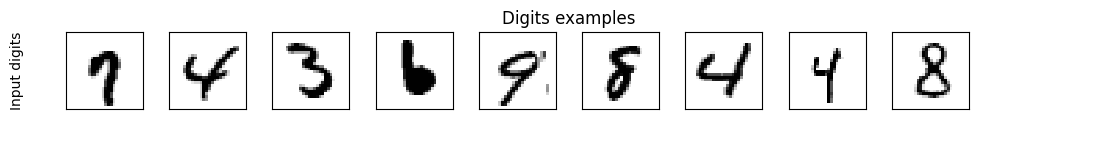

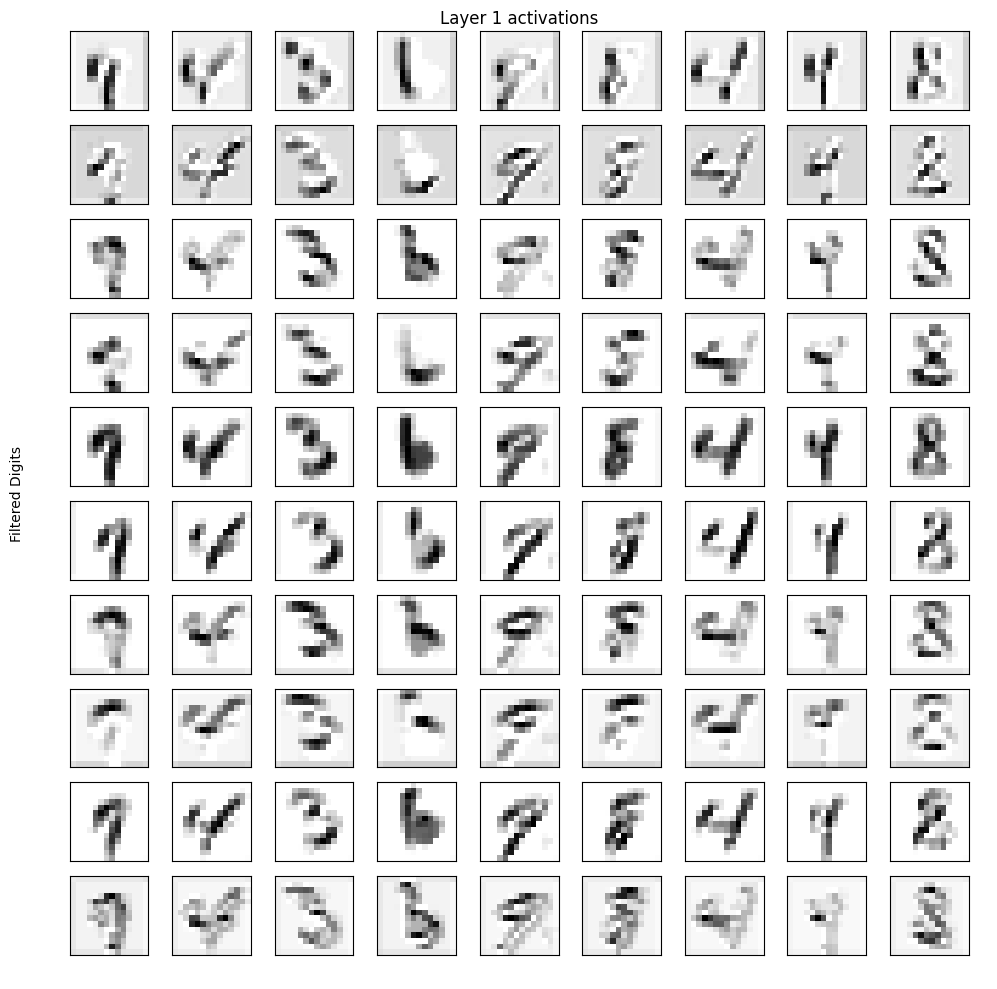

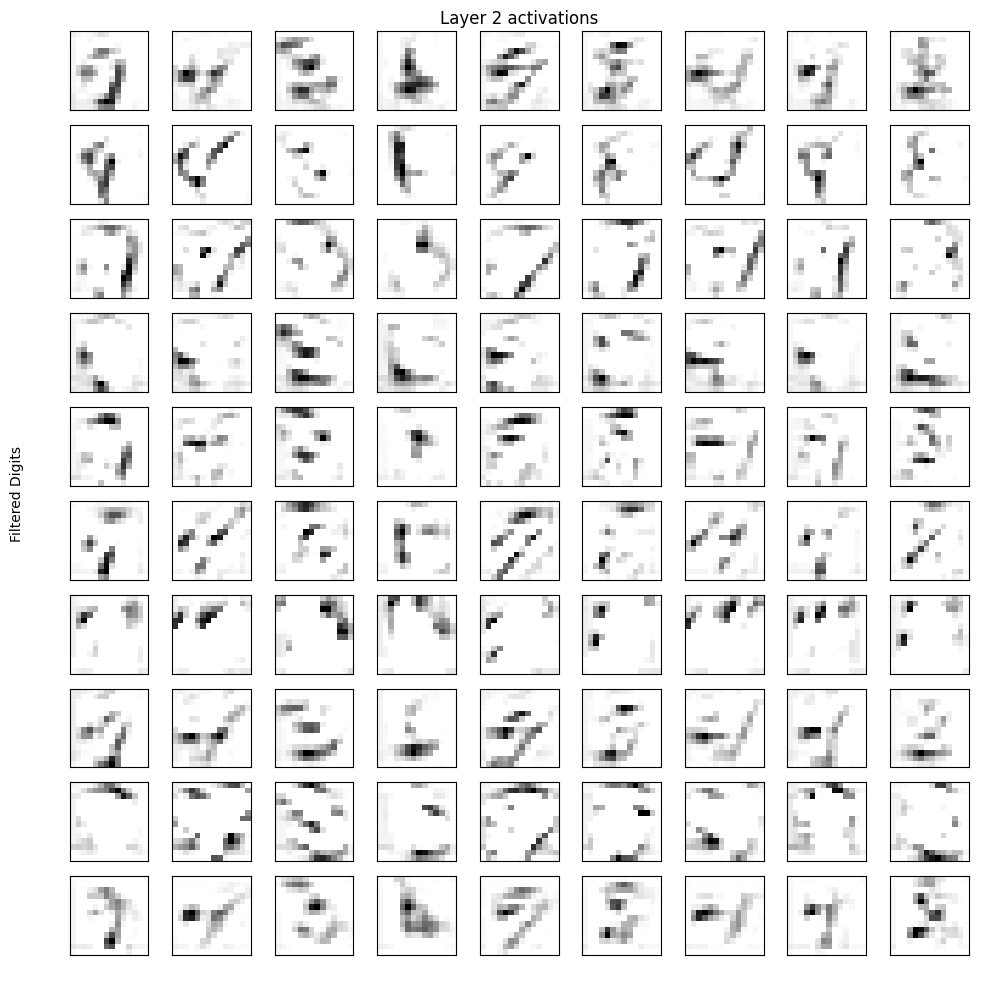

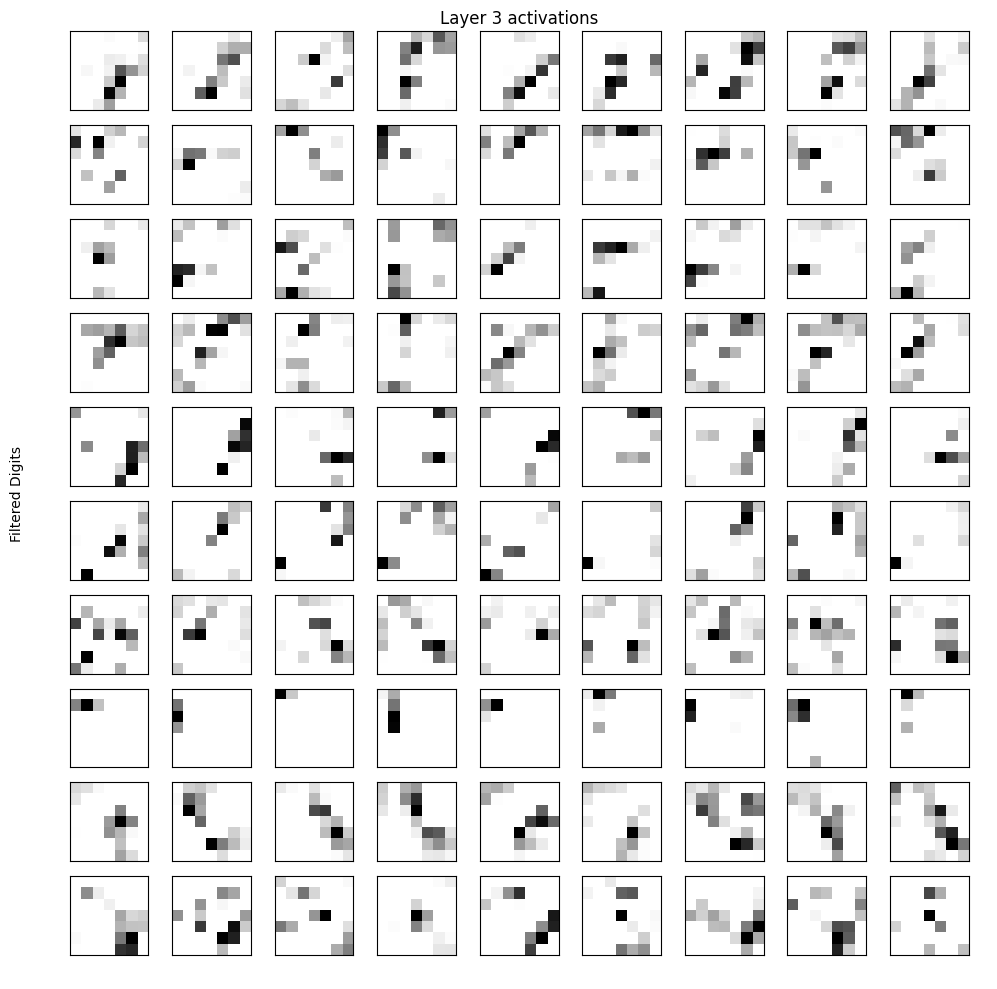

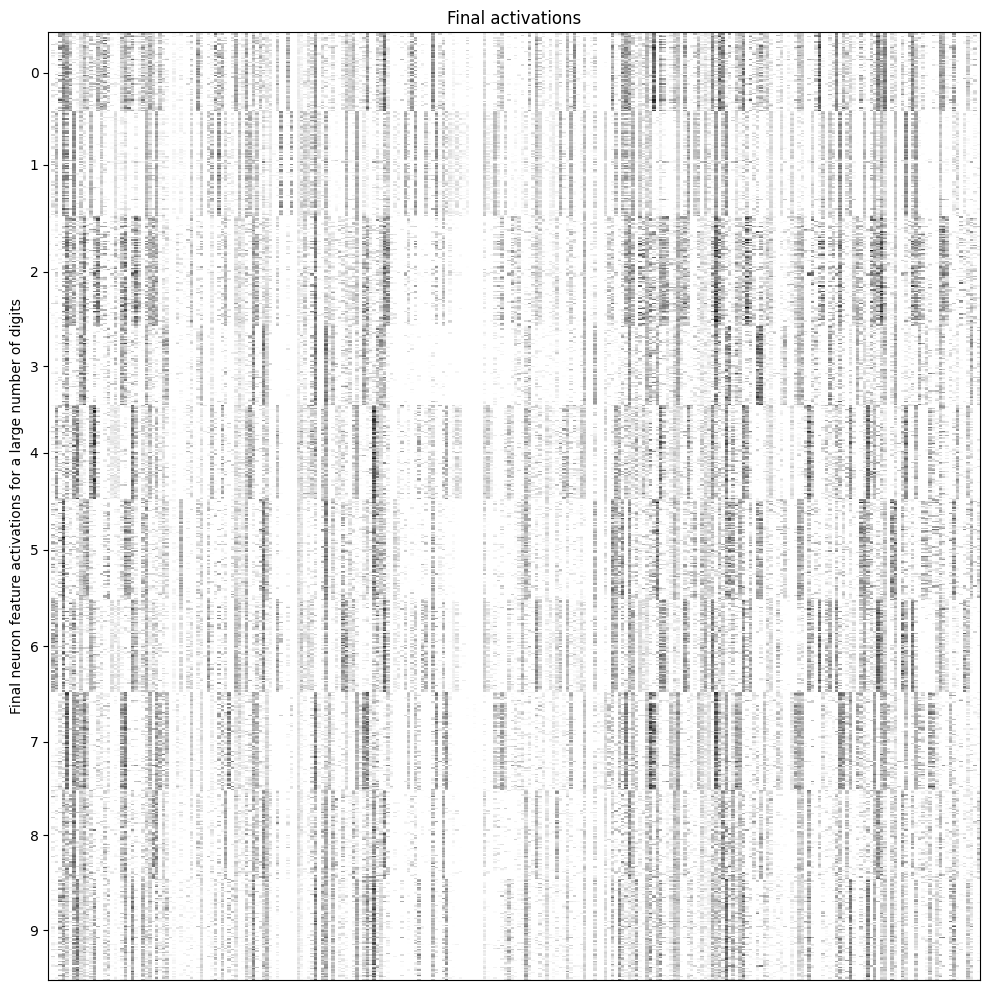

In [22]:
#@title Code
!pip install torchfunc --quiet

import torchvision
import torchfunc
from matplotlib import cm

cmap = cm.get_cmap('gray_r')

recorder = torchfunc.hooks.recorders.ForwardPre()
recorder.modules(networkCNN)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  networkCNN(example_data[0:9])

fig = plt.figure(figsize=(13.1, 1))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(9):
  for i in range(1):
    plt.subplot(1,10,j+1)
    plt.imshow(example_data[j][0], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Input digits")
ax.set_title("Digits examples")
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[2][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 1 activations")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[3][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 2 activations")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[4][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 3 activations")
plt.tight_layout()
plt.show()

recorder = torchfunc.hooks.recorders.ForwardPre()
recorder.modules(networkCNN)

with torch.no_grad():
  batch, (ex_data_full, ex_target_full) = next(examples)
  for _ in range(10):
    batch, (ex_data, ex_target) = next(examples)
    ex_data_full = torch.cat((ex_data_full, ex_data), axis=0)
    ex_target_full = torch.cat((ex_target_full, ex_target), axis=0)

  ex_target_full_idx = np.argsort(ex_target_full)
  ex_data_full = ex_data_full[ex_target_full_idx]
  networkCNN(ex_data_full)

CNN_output_embedding = recorder.data[5][0]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(recorder.data[5][0], cmap=cmap, interpolation='none', aspect='auto')

embedding_ticks = []
cumulative_ticks = 0
for num in range(10):
  tick_length = np.sum(num == ex_target_full.detach().numpy())#/len(ex_target_full_idx)
  cumulative_ticks += tick_length
  embedding_ticks.append(cumulative_ticks - tick_length/2)

plt.xticks([])
plt.yticks(embedding_ticks, [i for i in range(10)])

ax.set_title("Final activations")
ax.set_ylabel("Final neuron feature activations for a large number of digits")
plt.tight_layout()
plt.show()


As we can see, after just one layer the images quickly start to loose their original geometry, instead representing abstractions of shapes found in layer 1. Looking at the filter activations for the different numbers for the first layers, we can see that the filters in many cases correspond to different types of edge dectection. Some filters identify vertical edges, some horizontal, some angled edges. It is these features which are then combined hierachically on the later layers to enable the network do identify the different numbers.

The final image shows what the final layer of filter activations looks like for a larget number of numbers, after being flattened into a 1-dimensional array and grouped together. We can see that it is pretty easy to destinguish the different groups of digits from each other, which is what the final layers of the neural network learns to do. But just how easy? Lets do some data analysis to see how the CNN simplifies the task of the nerual network to identify images. First we can plot a correlation matrix of the sorted examples to see how well each digit correlates to each other:

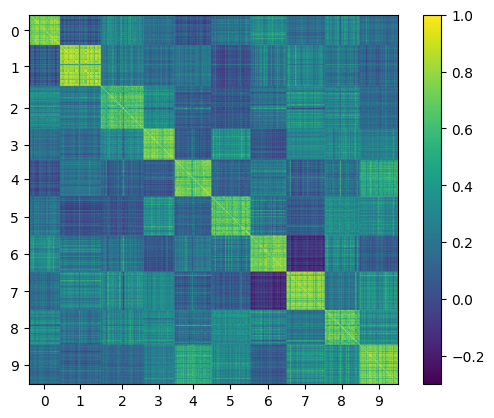

In [23]:
#@title Code
correlation = np.corrcoef(CNN_output_embedding)
plt.imshow(correlation)
plt.xticks(embedding_ticks, [i for i in range(10)])
plt.yticks(embedding_ticks, [i for i in range(10)])
plt.colorbar()


Here we see that there is a high degree of auto-correlation within each group of numbers. We can also see that some numbers on average are more similar to other numbers, and some less similar. For example, looking at 6 and 7 we can see that they are not very similar to each other, while 2 and 3 are comparatively similar to each other. For the correlation of the embedding dimension we can also see that the number 2 seems that have the largest degree of variability in terms of how it is written. What does the correlation look like when not using CNNs for embedding?

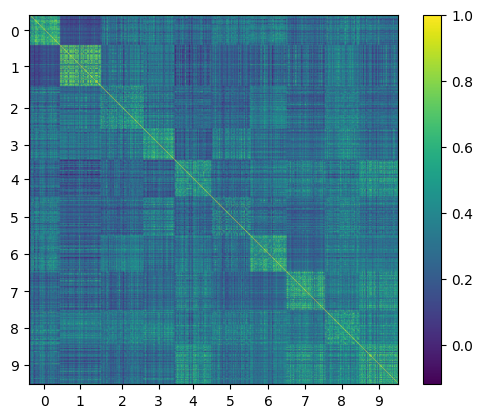

In [24]:
#@title Code
correlation = np.corrcoef(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))
plt.imshow(correlation)
plt.xticks(embedding_ticks, [i for i in range(10)])
plt.yticks(embedding_ticks, [i for i in range(10)])
plt.colorbar()


Here we see the benefit of using CNN for feature extraction: The identified features are more easy to separate for different digits than the raw pixel values which are shown here. Another way to visualize this is to use PCA to plot the data set and the embedded features:

Text(0.5, 0.98, 'PCA transformation on raw pixel and embeddings')

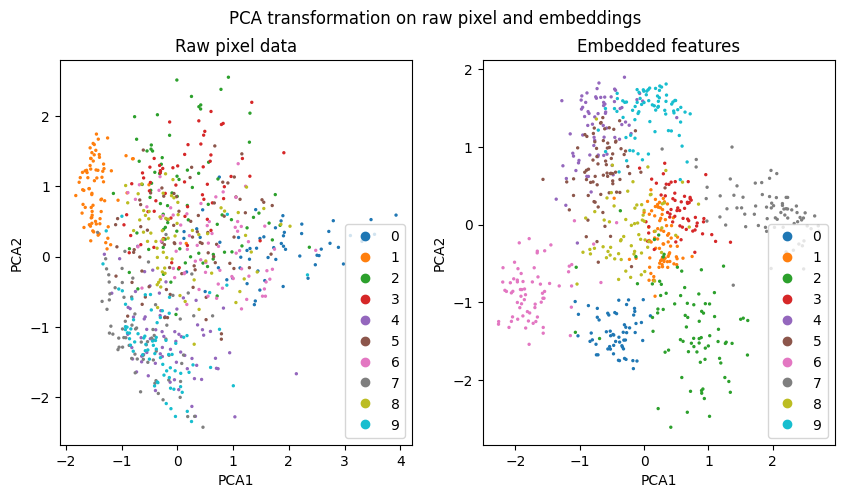

In [25]:
#@title Code
from sklearn.decomposition import PCA

pca_raw_ = PCA(n_components=2, whiten=True)
pca_raw = pca_raw_.fit_transform(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))
pca_embedding = PCA(n_components=2, whiten=True).fit_transform(CNN_output_embedding)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pca_scatter_raw = ax[0].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
pca_scatter_emb = ax[1].scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')

ax[0].set_title('Raw pixel data')
ax[1].set_title('Embedded features')

ax[0].set_xlabel("PCA1")
ax[0].set_ylabel("PCA2")

ax[1].set_xlabel("PCA1")
ax[1].set_ylabel("PCA2")

ax[0].legend(*pca_scatter_raw.legend_elements())
ax[1].legend(*pca_scatter_emb.legend_elements())

plt.suptitle("PCA transformation on raw pixel and embeddings")


Here, the different numbers are colored to show how the numbers are represented by the principal components. As we can see, the CNN embedding are more easily separate even when only using two principal components.

Now that we have reduced out data set to two different principal components for both the raw data there is a nice trick we can do. Since the images are represented using two components, we can use the inverse of these components to see how the digits would look for our synthetic data points.

None


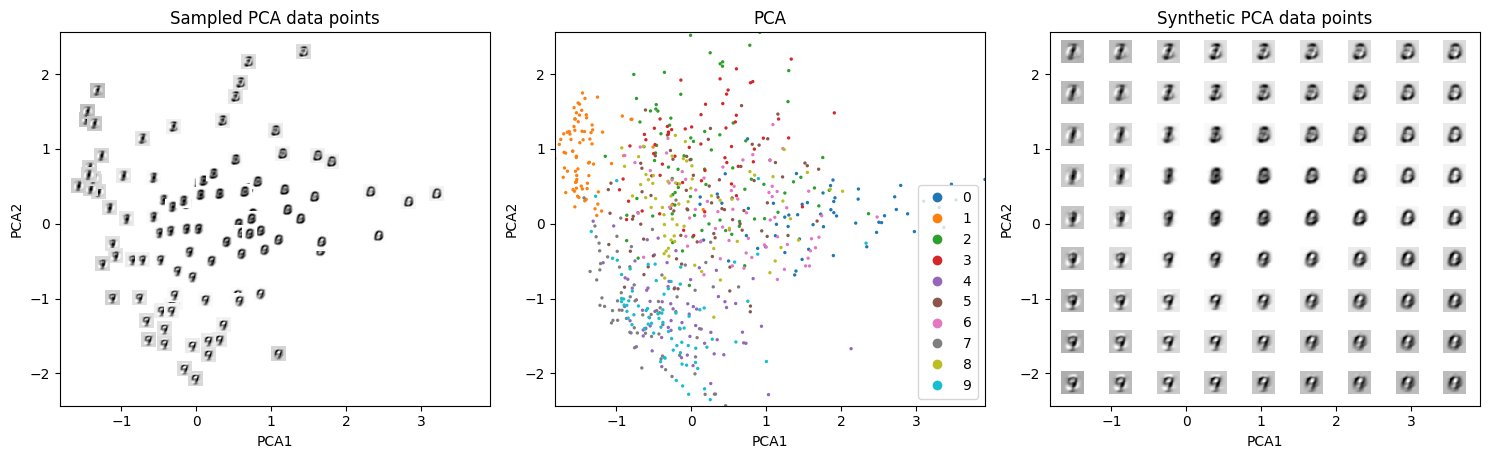

In [26]:
#@title Code

im_size = 0.2
n_images = 100

sampled_points = pca_raw[np.random.choice(len(pca_raw), n_images, replace=False)]

raw_inverse = pca_raw_.inverse_transform(sampled_points)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for i in range(3):
  ax[i].set_xlim(np.min(pca_raw[:, 0]), np.max(pca_raw[:, 0]))
  ax[i].set_ylim(np.min(pca_raw[:, 1]), np.max(pca_raw[:, 1]))

for ind, im in enumerate(raw_inverse):
  image = im.reshape(28, 28)
  ax[0].imshow(image, interpolation='none', cmap=cmap, extent=(sampled_points[ind, 0], sampled_points[ind, 0] + im_size, sampled_points[ind, 1], sampled_points[ind, 1] + im_size,))

pca_scatter_raw = ax[1].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
ax[1].legend(*pca_scatter_raw.legend_elements())

print(ax[1].set_aspect(1))

pca1_range = np.linspace(np.min(pca_raw[:, 0]), np.max(pca_raw[:, 0]), 10)
pca2_range = np.linspace(np.min(pca_raw[:, 1]), np.max(pca_raw[:, 1]), 10)

grid = []

for a in pca1_range:
  for b in pca2_range:
    grid.append([a, b])

grid = np.vstack(grid)

raw_inverse = pca_raw_.inverse_transform(grid)

im_size = 0.3

for ind, im in enumerate(raw_inverse):
  image = im.reshape(28, 28)
  ax[2].imshow(image, interpolation='none', cmap=cmap, extent=(grid[ind, 0] + im_size/2, grid[ind, 0] + im_size + im_size/2, grid[ind, 1] + im_size/2, grid[ind, 1] + im_size + im_size/2,))

for i in range(3):
  ax[i].set_xlabel("PCA1")
  ax[i].set_ylabel("PCA2")

ax[0].set_title('Sampled PCA data points')
ax[1].set_title('PCA')
ax[2].set_title('Synthetic PCA data points')

plt.tight_layout()
plt.show()


As PCA is a linear methods of dimensionality reduction the reconstruction is both simple and very lossy. While some numbers are reconstructed pretty well, for example the number 9, 1 and 0, others are more difficult to reconstruct.

What if we leave the area of linear methods for dimensionality reduction and venture into the area of non-linear methods? One commonly used method is called Uniform Manifold Approximation and Projection, or UMAP. This method constructs a topographic representation of the data in it's native dimension, in our case 784 dimensions, and tries to reconstruct the same graph in a lower dimension, minimizing the information loss in the transition between the higher dimension representation and the lower dimension representationl.

Text(0.5, 0.98, 'PCA transformation on raw pixel data compared to UMAP')

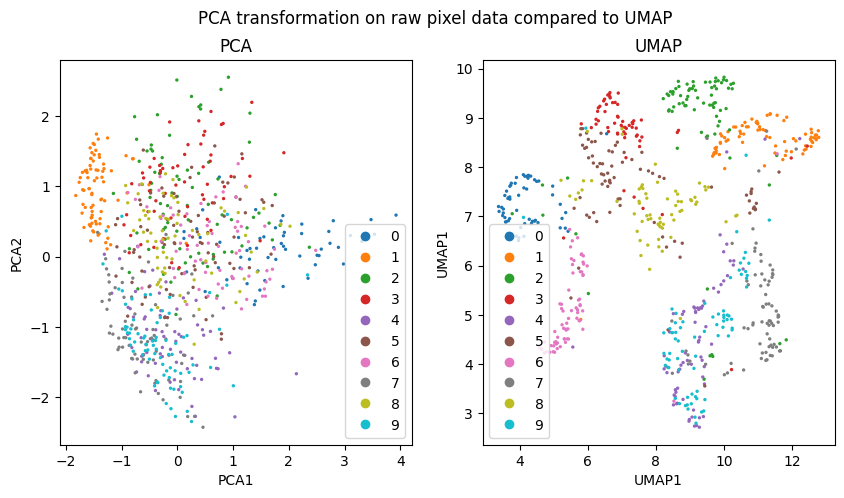

In [27]:
from umap import UMAP

umap_raw = UMAP(n_components=2)

umap_data = umap_raw.fit_transform(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pca_scatter_raw = ax[0].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
umap_scatter_emb = ax[1].scatter(umap_data[:, 0], umap_data[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')

ax[0].set_title('PCA')
ax[1].set_title('UMAP')

ax[0].set_xlabel("PCA1")
ax[0].set_ylabel("PCA2")

ax[1].set_xlabel("UMAP component 1")
ax[1].set_ylabel("UMAP component 2")

ax[0].legend(*pca_scatter_raw.legend_elements())
ax[1].legend(*umap_scatter_emb.legend_elements())

plt.suptitle("PCA transformation on raw pixel data compared to UMAP")



Here we see the benefit of applying non-linear feature reduction to the data: the hand written numbers are relatively well-grouped into its corresponding classes, even when reduced to two dimensions. There are some important difference when comparing UMAP to PCA, however. While PCA is solved iteratively for each dimension using linear algebra, UMAP uses a gradient descent approach where each compenent of the lower dimensionalo representation are adjusted iteratively. This has the effect that the UMAP representation has a certain amount of randomness, running the same algorithm on the same data using diffierent initializations will results in different results. UMAP also has more hyperparameters than PCA which must be tuned for optimal performance.

So, UMAP performs pretty well in 2 dimensions, almost providing cleanly separable data points without any training. Well, what about 3 dimensions?

Text(0.5, 0.98, 'UMAP using 3 dimensional representation.')

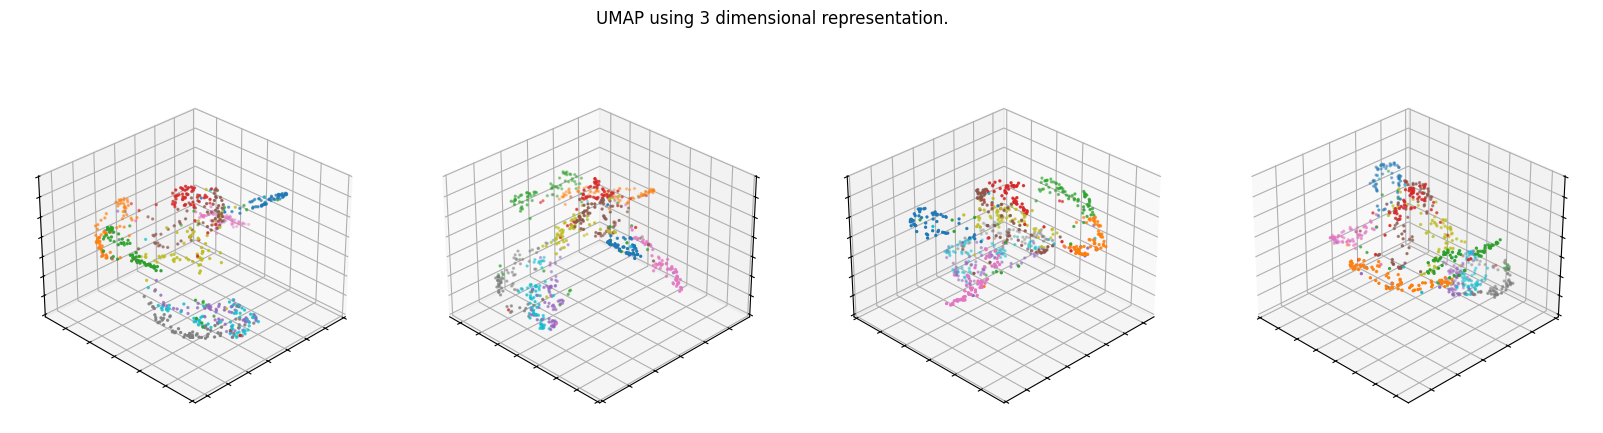

In [40]:
umap_raw = UMAP(n_components=3)

umap_data = umap_raw.fit_transform(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))

fig, ax = plt.subplots(ncols=4, figsize=(20,5), subplot_kw=dict(projection='3d'))

for i in range(4):
  ax[i].scatter(umap_data[:, 0], umap_data[:, 1], umap_data[:, 2], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
  ax[i].view_init(elev=30., azim=i * 90 + 45)

  ax[i].xaxis.set_ticklabels([])
  ax[i].yaxis.set_ticklabels([])
  ax[i].zaxis.set_ticklabels([])

plt.suptitle("UMAP using 3 dimensional representation.")


That do look pretty separable, what if we incorporate UMAP in out training pipeline?